# INTRO

In [ ]:
!pip install patool opencv-python pydot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import patoolib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve
)

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape,
    Lambda, BatchNormalization, Dropout, Activation, AveragePooling2D,
    GlobalAveragePooling2D, Concatenate, Cropping2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import backend as K, layers, models

In [ ]:
# Extract the .rar file
patoolib.extract_archive("/content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar", outdir="datasets")

INFO patool: Extracting /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar ...
INFO:patool:Extracting /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar ...
INFO patool: ... creating output directory `datasets'.
INFO:patool:... creating output directory `datasets'.
INFO patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar"
INFO:patool:running /usr/bin/unrar x -- "/content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar"
INFO patool:     with cwd='datasets', input=''
INFO:patool:    with cwd='datasets', input=''
INFO patool: ... /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar extracted to `datasets'.
INFO:patool:... /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar extracted to `datasets'.


'datasets'

In [ ]:
# DATA PREPROCESSING
# The dataset (images) are preprocessed by setting the paths to the dataset,
# resizing, normalising and splitting them into train and test dataset.

benign_path = "./datasets/Dataset of Mammography with Benign Malignant Breast Masses/MIAS Dataset/Benign Masses"
malignant_path = "./datasets/Dataset of Mammography with Benign Malignant Breast Masses/MIAS Dataset/Malignant Masses"
images = []
labels = []


# A function 'load images from folder" is created to load load images from a directory with reduced size
def load_images_from_folder(folder, label):
    count = 0
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # reducing image size from 227*227
            img = img / 255.0  # images are Normalised
            images.append(img)
            labels.append(label)
            count += 1
    return count

# Reload the images after reducing the size
images = []
labels = []

# Load and count the number of benign images
benign_count = load_images_from_folder(benign_path, 0)
print(f" The number of benign images: {benign_count}")


# Load and count the number of malignant images
malignant_count = load_images_from_folder(malignant_path, 1)
print(f"The number of malignant images: {malignant_count}")


# The lists are Converted to numpy arrays
images = np.array(images, dtype='float32') # Float32 is used to reduce memory usage
labels = np.array(labels)


# The images are reshaped to include the channel dimension
images = images.reshape(-1, 128, 128, 1)

 The number of benign images: 2376
The number of malignant images: 1440


In [ ]:
# SPLITTING AND TRAINING THE DATASET
# The dataset is split into training and testing sets using the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Data augmentation to reduce overfitting and enhance model learning
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [ ]:
# Function to display some sample images from the dataset
def display_sample_images(images, labels, sample_size=8):
    plt.figure(figsize=(10, 10))
    for i in range(sample_size):
        plt.subplot(1, sample_size, i+1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title('Malignant' if labels[i] == 1 else 'Benign')
        plt.axis('off')
    plt.show()

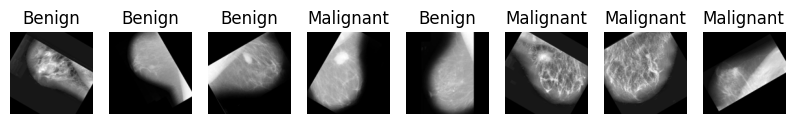

In [ ]:
display_sample_images(X_train, y_train)

## Project Title: Anomaly Detection in Mammography using CNN and Autoencoders

### Research Questions
Investigate the features of Convolutional Autoencoder (CAE) and Variational Autoencoder (VAE) vs DenseNets (CNN), How does different feature extraction techniques impact their performance in identifying anomalies in mammographic images?
Comparing the efficacy of Convolutional Autoencoder (CAE) and Variational Autoencoder (VAE) vs DenseNets (CNN), which of them is the most accurate in identifying anomalies in mammography images?

### Project Objectives
The primary objective of this project is to develop and evaluate advanced machine-learning models for detecting anomalies in mammography images. I will compare the performance of convolutional autoencoders (CAE) and variational autoencoders (VAE) against DenseNets (CNN) in identifying these anomalies to determine which model provides higher accuracy and reliability in anomaly detection. Another goal is to assess the computational efficiency and scalability of each model when applied to large datasets of mammography images. Additionally, the project intends to explore the interpretability of the model's outputs to ensure they can be effectively used in clinical settings. The project will provide insights into the strengths and weaknesses of each approach, and the findings from this report will contribute to improving the early detection of breast cancer through more accurate and efficient anomaly detection methods.

### Summary of project and background
This project focuses on the application of advanced machine learning techniques to detect anomalies in mammography images, which is crucial for early breast cancer detection. The research compares the efficacy of Convolutional Autoencoders (CAE) and Variational Autoencoders (VAE) with DenseNets (CNN) in identifying these anomalies. Mammography is a widely used screening tool for breast cancer, but the interpretation of images can be challenging and prone to human error. By leveraging deep learning models, the project aims to enhance the accuracy  and reliability of anomaly detection, potentially leading to better clinical outcomes. The background of this project lies in the need for more effective and automated methods to assist radiologists in diagnosing breast cancer. The use of CAE, VAE, and CNN models represents a cutting-edge approach in the field of medical image analysis. This research will contribute to the ongoing efforts to improve breast cancer screening and diagnosis through technological advancements.